# QuartzNet model

In [18]:
import string
import re
import json
from typing import Dict, Union
from collections import OrderedDict, defaultdict
from IPython.display import clear_output
import copy
import gc
import random
from tqdm import tqdm
import sys

import numpy as np
import mlflow

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torch_optimizer as optim

from datasets import load_metric

import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Set seed to all processes

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
set_seed(42)

## Data preprocessor

In [4]:
class Unsqueeze(nn.Module):
    def __init__(self, dim=0):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.unsqueeze(self.dim)

In [5]:
class ASRProcessor(object):
    def __init__(self, sampling_rate=16000, n_fft=1024, hop_length=256, n_mels=64, split='test'):
        self.mel_spec_processor = torchaudio.transforms.MelSpectrogram(
            sample_rate=sampling_rate, 
            n_fft=n_fft, 
            hop_length=hop_length, 
            n_mels=n_mels
        )
        
        if split == 'train':
            self.augmentation = nn.Sequential(
                Unsqueeze(), 
                torchaudio.transforms.TimeMasking(time_mask_param=5), 
                torchaudio.transforms.FrequencyMasking(freq_mask_param=5), 
            )
        else:
            self.augmentation = None
        
        self.let2idx = ["-", " ", "'", "<PAD>"]
        self.let2idx.extend([s for s in string.ascii_lowercase])
        self.vocab = {w: idx for idx, w in enumerate(self.let2idx)}

    def text_processor(self, text):        
        return torch.LongTensor([self.vocab[symbol] for symbol in text])
    
    def __call__(self, input_values: torch.tensor, labels: str) -> Dict[str, Union[torch.tensor, torch.LongTensor]]:
        log_mel_spec_image = self.mel_spec_processor(input_values)
        input_preprocessed = self.augmentation(log_mel_spec_image).squeeze(0) \
                                if self.augmentation is not None else log_mel_spec_image
        
        text_preprocessed = self.text_processor(labels)
        
        return {
            'input_features': input_preprocessed, 
            'labels': text_preprocessed
        }
    
    def CTCDecode(self, input_string):
        split_by_sep_token = input_string.split("-")
        del_duplicates = map(lambda x: re.sub(r'([a-z])\1+', r'\1', x), split_by_sep_token)
        
        return ''.join(del_duplicates)
    
    def labels_decode(self, batched_labels):
        pad_idx = self.vocab["<PAD>"]
        space_idx = self.vocab[" "]
        decoding_labels = batched_labels.clone().detach()
        
        decoding_labels[decoding_labels == pad_idx] = space_idx
        return [
            self.CTCDecode(''.join([self.let2idx[l] for l in bl]).strip()) 
                for bl in decoding_labels
        ]

## Dataset

In [6]:
class LibriDataset(Dataset):
    def __init__(self, processor, root='', split='dev-clean'):
        assert split in ['dev-clean', 'dev-other', 'test-clean', 'test-other', 'train-clean-100'], \
                'Split error!'
        
        self.data_iterator = torchaudio.datasets.LIBRISPEECH(root=root, url=split)
        
        self.processor = processor
        
    def __getitem__(self, idx):
        sample = self.data_iterator[idx]
        sample = self.processor(sample[0][0], sample[2].lower())
        
        return sample
    
    def __len__(self):
        return len(self.data_iterator)
    
    @staticmethod
    def normalize_batch(sample):
        input_features = sample['input_features']
        all_means = torch.zeros(input_features.size(0))
        all_stds = torch.zeros(input_features.size(0))

        for s_idx, s_len in enumerate(sample['input_lengths']):
            valid_features = input_features[s_idx, :, :s_len]
            sample_mean = torch.mean(valid_features)
            all_means[s_idx] = sample_mean
            all_stds[s_idx] = torch.sqrt(torch.mean(valid_features**2) - sample_mean**2)

        return (input_features - all_means.view(-1, 1, 1)) / all_stds.view(-1, 1, 1)
    
    @staticmethod
    def batch_collate(batch):
        # Collate audio samples.  
        sample_tokens_lengths = torch.tensor([x['input_features'].size(1) for x in batch])
        max_len_per_samples = torch.max(sample_tokens_lengths)
        
        # Extend to even max_len.  
        additive = (max_len_per_samples % 2)
        max_len_per_samples += additive
        samples_lengths_to_pad = max_len_per_samples - sample_tokens_lengths - additive
        
        input_features = torch.stack([
            F.pad(x['input_features'], pad=(0, val_to_pad)) 
            for x, val_to_pad in zip(batch, samples_lengths_to_pad)
        ])
        
        # Collate label samples.  
        label_tokens_lengths = torch.tensor([x['labels'].size(0) for x in batch])
        max_len_per_labels = torch.max(label_tokens_lengths)
        
        # Extend to even max_len.  
        additive = (max_len_per_labels % 2)
        max_len_per_labels += additive
        labels_lengths_to_pad = max_len_per_labels - label_tokens_lengths - additive

        labels = torch.vstack([
            F.pad(x['labels'], pad=(0, val_to_pad)) 
            for x, val_to_pad in zip(batch, labels_lengths_to_pad)
        ]).type(torch.int64)
        
        collated = {
            'input_features': input_features, 
            'input_lengths': torch.ceil(sample_tokens_lengths / 2).type(torch.int64), 
            'targets': labels, 
            'target_lengths': label_tokens_lengths
        }
        
        collated['input_features'] = LibriDataset.normalize_batch(collated)
        
        return collated

In [24]:
def set_split(batch_size=32, train_shuffle=False):
    train_processor = ASRProcessor(split='train')
    test_processor = ASRProcessor(split='test')
    
    datasets = {
        'train': LibriDataset(train_processor, split='train-clean-100'), 
        'val': LibriDataset(test_processor, split='dev-clean'), 
        'test': LibriDataset(test_processor, split='test-clean')
    }
    
    dataloaders = {
        k: DataLoader(datasets[k], batch_size=64, shuffle=False, 
                        collate_fn=LibriDataset.batch_collate, num_workers=4)
        for k in ['val', 'test']
    }
    
    dataloaders['train'] = DataLoader(datasets['train'], batch_size=batch_size, shuffle=train_shuffle, 
                        collate_fn=LibriDataset.batch_collate, num_workers=4)
    
    return datasets, dataloaders

## Model (QuartzNet 5x5)

In [8]:
class SingleBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, activation=True):
        super().__init__()
        
        # Padding 'same'.  
        padding = (kernel_size // 2) * dilation
        
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size, stride, 
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.batch_norm = nn.BatchNorm1d(num_features=out_channels)
        self.activation = activation
        
    def forward(self, x):
        TCS_out = self.pointwise(self.depthwise(x))
        
        bn_out = self.batch_norm(TCS_out)
        
        return F.relu(bn_out) if self.activation else bn_out

In [9]:
class RepeatedBBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, R=5):
        super().__init__()
        
        # The first block to match in_channels and out_channels.  
        self.B = [SingleBBlock(in_channels, out_channels, kernel_size, stride, dilation, activation=True)]
        
        # BBlocks between the first and the last blocks.  
        self.B.extend([
            SingleBBlock(out_channels, out_channels, kernel_size, stride, dilation, activation=True)
            for _ in range(R - 2)
        ])
        
        # The last block to prevent nonlinearity.  
        self.B.append(SingleBBlock(out_channels, out_channels, kernel_size, stride, dilation, activation=False))
        self.B = nn.Sequential(*self.B)
        
        # Skip connection.  
        self.skip_connection = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1), 
            nn.BatchNorm1d(num_features=out_channels)
        )
        
    def forward(self, x):
        RBlocks_out = self.B(x)
        skip_out = self.skip_connection(x)
        
        return F.relu(RBlocks_out + skip_out)

In [10]:
class QuartzNet(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        
        self.C1 = SingleBBlock(
            in_channels=n_features, out_channels=256, kernel_size=33, 
            stride=2, dilation=1, activation=True
        )
        
        self.B = nn.Sequential(
            OrderedDict([
                ('B1', RepeatedBBlocks(in_channels=256, out_channels=256, kernel_size=33, stride=1, dilation=1, R=5)), 
                ('B2', RepeatedBBlocks(in_channels=256, out_channels=256, kernel_size=39, stride=1, dilation=1, R=5)), 
                ('B3', RepeatedBBlocks(in_channels=256, out_channels=512, kernel_size=51, stride=1, dilation=1, R=5)), 
                ('B4', RepeatedBBlocks(in_channels=512, out_channels=512, kernel_size=63, stride=1, dilation=1, R=5)), 
                ('B5', RepeatedBBlocks(in_channels=512, out_channels=512, kernel_size=75, stride=1, dilation=1, R=5))
            ])
        )
        self.C2 = SingleBBlock(
            in_channels=512, out_channels=512, kernel_size=87, stride=1, dilation=2, activation=True
        )
        
        self.C3 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=1, stride=1, dilation=1), 
            nn.BatchNorm1d(num_features=1024), 
            nn.ReLU()
        )
        self.C4 = nn.Conv1d(in_channels=1024, out_channels=n_classes, kernel_size=1, stride=1, dilation=1)
        
    def forward(self, x):
        first_conv_out = self.C1(x)

        b_out = self.B(first_conv_out)
        c2_out = self.C2(b_out)
        c3_out = self.C3(c2_out)
        c4_out = self.C4(c3_out)
        
        return c4_out

## Load from checkpoint

In [11]:
def load_from_checkpoint(checkpoint_path, device=torch.device('cpu')):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    epoch = checkpoint['epoch']
    model = checkpoint['model_architecture'].to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    history = checkpoint['whole_history']

    if checkpoint['scheduler']:
        scheduler = checkpoint['scheduler']
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    return {
        'model': model, 
        'optimizer': optimizer, 
        'scheduler': scheduler if checkpoint['scheduler'] else None,
        'history': history,
        'epoch': epoch
    }

## Metrics and validation

In [12]:
class Metrics(nn.Module):
    def __init__(self):
        super().__init__()
        self.wer_metric = load_metric('wer')
        self.processor = ASRProcessor()
        
    def forward(self, y_pred, y_true):
        """
        Forward of labels prediction:
        :param y_pred: log_softmax(output) of the model, shape: (T, B, C), 
        :param y_true: true labels, shape (B, T)
        """
        pred_ids = torch.argmax(y_pred, dim=2).T
    
        pred_str = self.processor.labels_decode(pred_ids)
        label_str = self.processor.labels_decode(y_true)

        wer = self.wer_metric.compute(predictions=pred_str, references=label_str)

        return wer

In [13]:
def validate_model(model, val_dataloader, criterion, metrics, 
                    device=torch.device('cpu'), return_train=False):
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    
    with torch.inference_mode():
        print("\n")
        for batch_idx, sample in enumerate(val_dataloader):
            if batch_idx % 10 == 0 or batch_idx == len(val_dataloader) - 1:
                print(f"==> Batch: {batch_idx}/{len(val_dataloader)}")
            
            sample = {k: v.to(device) for k, v in sample.items()}
            
            y_pred = model(sample['input_features'])
            sample['log_probs'] = F.log_softmax(y_pred, dim=1).permute(2, 0, 1)
            del sample['input_features']
            
            loss = criterion(**sample)

            running_loss += loss.item()
            running_score += metrics(sample['log_probs'], sample['targets'])

        running_loss /= len(val_dataloader)
        running_score /= len(val_dataloader)
        
    if return_train:
        model.train()

    return running_loss, running_score

## Train function

In [14]:
def train(model, dataloaders, criterion, optimizer, metrics, scheduler=None, 
          num_epochs=5, start_epoch=-1, prev_metrics=dict(), device=torch.device('cpu'),
          folder_for_checkpoints='/'):
    for key, vals in prev_metrics.items():
        for val in vals:
            mlflow.log_metric(key, val[1])

    if len(prev_metrics) > 0:
        history = copy.deepcopy(prev_metrics)
        curr_step = prev_metrics['train_loss'][-1][0] + 1
    else:
        history = defaultdict(list)
        curr_step = 1

    model.train()
    for epoch in range(start_epoch + 1, start_epoch + 1 + num_epochs):
        running_loss = 0.0
        running_score = 0.0

        clear_output(True)

        print("-" * 20)
        print(f"Epoch: {epoch}/{start_epoch + num_epochs}")
        print("-" * 20)
        print("Train: ")

        for batch_idx, sample in enumerate(tqdm(dataloaders['train'])):            
            sample = {k: v.to(device) for k, v in sample.items()}
            
            y_pred = model(sample['input_features'])
            sample['log_probs'] = F.log_softmax(y_pred, dim=1).permute(2, 0, 1)
            del sample['input_features']
            
            loss = criterion(**sample)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            
            running_loss += loss.item()

            running_score += metrics(sample['log_probs'], sample['targets'])

        val_loss, val_metrics = validate_model(model, dataloaders['val'], criterion, 
                                                    metrics, device, return_train=True)

        mlflow.log_metric('train_loss', running_loss / (batch_idx + 1))
        mlflow.log_metric('val_loss', val_loss)
        history['train_loss'].append((curr_step, running_loss / (batch_idx + 1)))
        history['val_loss'].append((curr_step, val_loss))

        mlflow.log_metric('val_wer', val_metrics)
        history['val_wer'].append((curr_step, val_metrics))

        mlflow.log_metric('train_wer', running_score / (batch_idx + 1))
        history['train_wer'].append((curr_step, running_score / (batch_idx + 1)))

        curr_step += 1

        state = {
            'epoch': epoch,
            'batch_size_training': dataloaders['train'].batch_size,
            'model_architecture': model,
            'model_state_dict': model.state_dict(),
            'optimizer': optimizer,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler if scheduler else None,
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'whole_history': history
        }

        torch.save(state, folder_for_checkpoints + f'checkpoint_epoch_{epoch + 1}.pt')

    return model, history

## Model configuration

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
LR = 3e-4
NUM_EPOCHS = 30
CHECKPOINT_PATH = "ASR_checkpoints/"
N_MELS = 64
NUM_CLASSES = len(ASRProcessor().vocab) - 1

## Init new model

In [21]:
try:
    del optimizer
    del model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

model = QuartzNet(n_features=N_MELS, n_classes=NUM_CLASSES).to(device)
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
START_EPOCH = -1
history = dict()

## Load model from checkpoint

In [ ]:
check = load_from_checkpoint('ASR_checkpoints/checkpoint_epoch_1.pt', DEVICE)
model = check['model']

optimizer = check['optimizer']
scheduler = check['scheduler']
history = check['history']

START_EPOCH = check['epoch']

In [22]:
metrics = Metrics()
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

## Split data

In [25]:
datasets, dataloaders = set_split(
    batch_size=BATCH_SIZE, train_shuffle=True
)

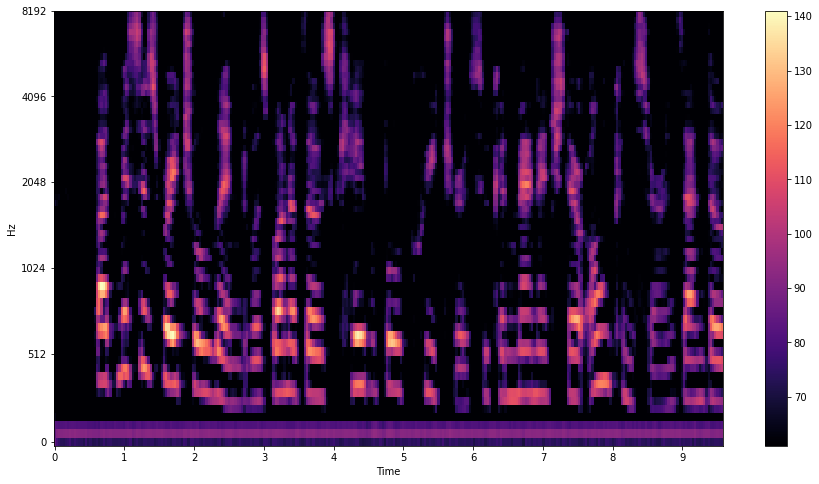

In [26]:
mel_spec_image = datasets['train'][4]['input_features'][:, :300]

plt.figure(figsize=(15, 8))
mel_sgram = librosa.amplitude_to_db(mel_spec_image, ref=np.min)
librosa.display.specshow(mel_sgram, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar()
plt.show()

In [27]:
validate_model(model, dataloaders['val'], criterion, metrics, device=device)



==> Batch: 0/43
==> Batch: 10/43
==> Batch: 20/43
==> Batch: 30/43
==> Batch: 40/43
==> Batch: 42/43


(5.592239368793576, 1.0)

## Training

In [ ]:
mlflow.set_tracking_uri('databricks')
mlflow.set_experiment("/Users/timkakhanovich@gmail.com/ASR/QuartzNet")

with mlflow.start_run(run_name="QuartzNet (with aug)"):
    mlflow.set_tags({
        'Python': '.'.join(map(str, sys.version_info[:3])), 
        'Device': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU', 
        'Dataset': 'LibriSpeech'
    })
    mlflow.log_param('batch_size', BATCH_SIZE)
    mlflow.log_param('lr', LR)
    
    train(
        model, dataloaders, criterion, optimizer, metrics, scheduler, num_epochs=NUM_EPOCHS, 
        start_epoch=START_EPOCH, prev_metrics=history, device=device, 
        folder_for_checkpoints=CHECKPOINT_PATH
    )

In [22]:
check = load_from_checkpoint('ASR_checkpoints/checkpoint_epoch_1.pt', DEVICE)
model = check['model']

optimizer = check['optimizer']
scheduler = check['scheduler']
history = check['history']

START_EPOCH = check['epoch']